# Deep Learning at Neuromatch 2021
Tanvi Ranjan, August 2021
## Week 2, Day 2: Modern Convnets and Transfer learning
[W2D2, Modern Convnets tutorial](https://deeplearning.neuromatch.io/tutorials/W2D2_ModernConvnets/student/W2D2_Tutorial1.html)

Training a ConvNet from scratch is useful for practice but the state of the art for Image classification has seen a lot of research and it is most likely useful to use pre-trained networks for image classification. A very useful figure in the evolution of ImageNets is shown in the slides on slide 21/74

TODO: [**Bonus** tutorial on Face Recognition](https://deeplearning.neuromatch.io/tutorials/W2D2_ModernConvnets/student/W2D2_Tutorial2.html)

In [78]:
# Import libraries
import os
import time
import tqdm
import torch
import IPython
import torchvision
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision.models import AlexNet
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from PIL import Image
from io import BytesIO

In [2]:
import random
import torch

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
        random.seed(seed)
        np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


#### 1.3: Using AlexNets
AlexNet(), published in 2012, is believed to herald the revolution of Deep learning for image classification. Next, we try to load it and see what the features are learning

In [3]:
# @title Import Alexnet
# @markdown This cell gives you the `alexnet` model as well as the `input_image` and `input_batch` variables used below
import requests, urllib

# original link: https://s3.amazonaws.com/pytorch/models/alexnet-owt-4df8aa71.pth
state_dict = torch.hub.load_state_dict_from_url("https://osf.io/9dzeu/download")

alexnet = AlexNet()
alexnet.load_state_dict(state_dict=state_dict)

url, filename = ("https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ModernConvnets/static/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)
preprocess = transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225]),
                                 ])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

Downloading: "https://osf.io/9dzeu/download" to /Users/tanviranjan/.cache/torch/hub/checkpoints/download


###### Section 1.3.1: What are the learned features?
Let's look at the individual filters of the first layer in this network.

I am not sure (but happy nevertheless) why my plots are much more colorful than the plots in the tutorial. But the underlying features are very similar - there are examples of edge detectors, thick edge detectors, diagnols etc

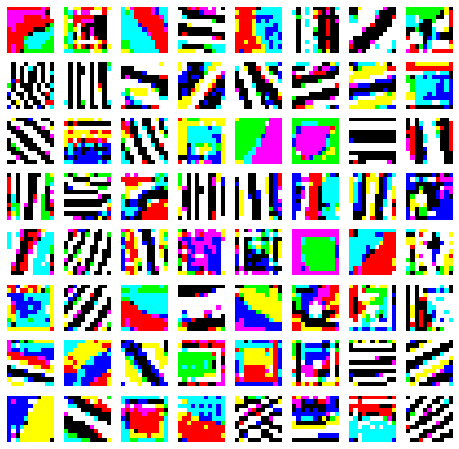

In [18]:
with torch.no_grad():
    params = list(alexnet.parameters());
    f,ax=plt.subplots(8,8,figsize=(8,8));ax=ax.flatten();
    for filter_index in range(params[0].shape[0]):
        filt = params[0][filter_index,:,:,:].permute(1,2,0)
        scale = np.abs(filt);
        filt = filt/(2*scale)+0.5; #scaling needed to get (-1,1)
        ax[filter_index].imshow(filt); ax[filter_index].axis('off')

###### Section 1.3.2: Output of filters
Now that we know what the output of features looks like, let's try to explore what the outputs of features looks like.

This is a [nice website](https://distill.pub/2017/feature-visualization/) to look at how features are learned in kernels of CNN, but a lot of images here trigger my trypophobia

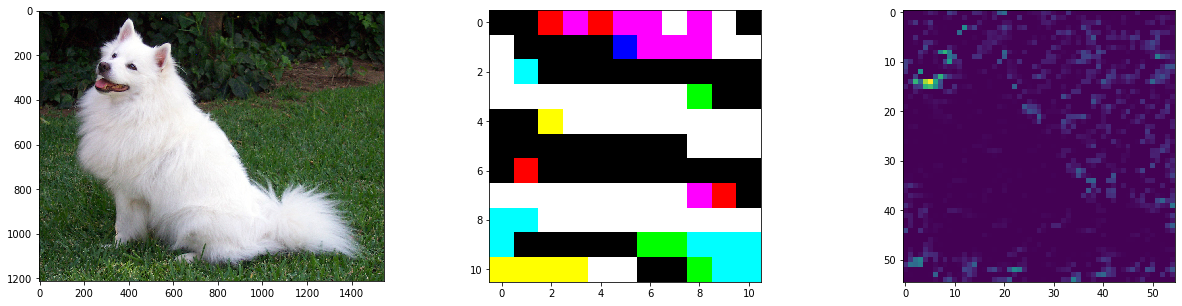

In [46]:
ifilt=3;
image = input_batch
intermediate_output = F.relu(alexnet.features[0](image));

f,ax=plt.subplots(1,3,figsize=(21,5))

with torch.no_grad():
    ax[0].imshow(input_image);

    filt = params[0][ifilt,:,:,:].permute(1,2,0)
    scale = np.abs(filt);
    filt = filt/(2*scale)+0.5; #scaling needed to get (-1,1)

    ax[1].imshow(filt)

    ax[2].imshow(intermediate_output[0,ifilt,:])

#### Section 1.4: Using ResNets
Residual Networks are another state-of-the-art model trained on ImageNet. Instead of trying to learn the function mapping from image to label directly, they try to learn the residuals of each function

Skipping the next two sections for now in the interest of getting to transfer learning
#### Section 1.5: ResXnets with more channels
#### Section 1.6: MobileNets

#### Section 1.7: Transfer learning 
Using pre-trained networks by fine-tuning them to customize them for use in your specific task. Here we explore 3 options to build a classifier to predict pokemon type:

* Fine-tune a pre-trained ResNet
* Train only the final classifier layer of the ResNet
* Train a ResNet from scratch

In [57]:
# @title Download Data
import zipfile, io

# original link: https://github.com/ben-heil/cis_522_data.git
url = 'https://osf.io/u4njm/download'

fname = 'small_pokemon_dataset'

if not os.path.exists(fname+'zip'):
    print("Data is being downloaded...")
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    print("The download has been completed.")
else:
    print("Data has already been downloaded.")



Data is being downloaded...
The download has been completed.


In [56]:
num_classes=0;
for folder in os.listdir('small_pokemon_dataset/'):
    num_classes+=1;
print(f'{num_classes} classes of pokemon')

9 classes of pokemon


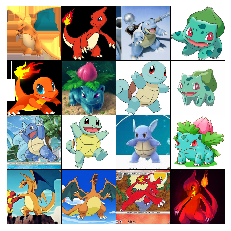

In [58]:
# @title Display Example Images
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

pokemon_dataset = ImageFolder('small_pokemon_dataset',
                              transform=train_transform)

image_count = len(pokemon_dataset)
train_indices = []
test_indices = []
for i in range(image_count):
  # Put ten percent of the images in the test set
    if random.random() < .1:
        test_indices.append(i)
    else:
        train_indices.append(i)

pokemon_test_set = torch.utils.data.Subset(pokemon_dataset, test_indices)
pokemon_train_set = torch.utils.data.Subset(pokemon_dataset, train_indices)

pokemon_train_loader = torch.utils.data.DataLoader(pokemon_train_set,
                                                   batch_size=16,
                                                   shuffle=True,)
pokemon_test_loader = torch.utils.data.DataLoader(pokemon_test_set,
                                                  batch_size=16)

dataiter = iter(pokemon_train_loader)
images, labels = dataiter.next()

# show images
plt.imshow(make_grid(images, nrow=4).permute(1, 2, 0))
plt.axis('off')
plt.show()

##### Define training loop

In [117]:
resnet = torchvision.models.resnet18(pretrained=True);
numftrs = resnet.fc.in_features;
resnet.fc = nn.Linear(numftrs,num_classes);
optimizer = optim.Adam(resnet.parameters(),lr=1e-4);
loss_fn = nn.CrossEntropyLoss();

def train_loop(model, loss_fn, optimizer):


    nepoch=20;

    train_loss=[]; train_acc=[]; test_loss=[]; test_acc=[]
    for epoch in tqdm(range(nepoch),position=0,leave=True):
        running_loss=0; acc_train=[];
        for batch in pokemon_train_loader:
            data, targets = batch;

            optimizer.zero_grad();
            output = model(data);
            loss = loss_fn(output, targets);
            loss.backward();
            optimizer.step();

            prediction = torch.argmax(output, dim=1)

            running_loss+= loss.item();
            acc_train.append((prediction==targets).sum()/len(targets))

        with torch.no_grad():
            test_running_loss=0;
            test_running_acc=[];
            for test_batch in pokemon_test_loader:
                test_data, test_targets = test_batch
                test_output = model(test_data);
                loss += loss_fn(test_output, test_targets).item();
                prediction = torch.argmax(test_output,dim=1);

                test_running_acc.append((prediction==test_targets).sum()/len(targets));

            test_running_loss = loss/len(pokemon_test_loader);



        train_loss.append(running_loss/len(pokemon_train_loader))
        train_acc.append(torch.tensor(acc_train).mean())

        test_loss.append(test_running_loss)
        test_acc.append(torch.tensor(test_running_acc).mean())

    return train_loss, train_acc, test_loss, test_acc
        

##### Option 1: Train classification layer only

In [118]:
resnet_cl = torchvision.models.resnet18(pretrained=True)
for param in resnet_cl.parameters():
    param.requires_grad=False
numftrs = resnet_cl.fc.in_features;
resnet_cl.fc = nn.Linear(numftrs,num_classes)
optimizer_cl = optim.Adam(resnet_cl.fc.parameters(),lr=1e-2)

train_cl_loss, train_cl_acc, test_cl_loss, test_cl_acc = train_loop(resnet_cl,
                                                                    loss_fn,optimizer_cl)



100%|██████████| 20/20 [17:15<00:00, 51.60s/it]


##### Option 2: Fine-tune pre-trained network

In [119]:
train_ft_loss, train_ft_acc, test_ft_loss, test_ft_acc = train_loop(resnet,
                                                                    loss_fn,optimizer)


100%|██████████| 20/20 [40:02<00:00, 120.05s/it]


##### Option 3: Train ResNet architecture from scratch

In [123]:
resnet_scratch = torchvision.models.resnet18(pretrained=False);
numftrs = resnet_scratch.fc.in_features;
resnet_scratch.fc = nn.Linear(numftrs,num_classes);
optimizer_scratch = optim.Adam(resnet_scratch.parameters(),lr=1e-4);

train_scratch_loss, train_scratch_acc, test_scratch_loss, test_scratch_acc = train_loop(resnet_scratch,
                                                                    loss_fn,optimizer_scratch)


100%|██████████| 20/20 [40:41<00:00, 119.14s/it]


##### Compare loss and accuracy in the three cases

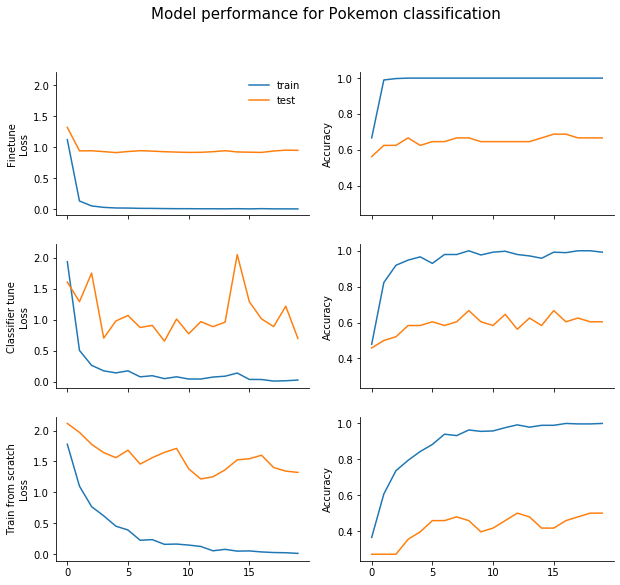

In [130]:
f,ax=plt.subplots(3,2,figsize=(10,9),sharex=True,sharey='col')
ax[0,0].plot(train_ft_loss,label='train'); sns.despine();
ax[0,0].plot(test_ft_loss,label='test'); ax[0,0].set_ylabel('Finetune\nLoss');
ax[0,0].legend(frameon=False)

ax[0,1].plot(train_ft_acc,label='train');
ax[0,1].plot(test_ft_acc,label='test'); ax[0,1].set_ylabel('Accuracy')

ax[1,0].plot(train_cl_loss,label='train'); sns.despine();
ax[1,0].plot(test_cl_loss,label='test'); ax[1,0].set_ylabel('Classifier tune\nLoss');

ax[1,1].plot(train_cl_acc,label='train');
ax[1,1].plot(test_cl_acc,label='test'); ax[1,1].set_ylabel('Accuracy')

ax[2,0].plot(train_scratch_loss,label='train'); sns.despine();
ax[2,0].plot(test_scratch_loss,label='test'); ax[2,0].set_ylabel('Train from scratch\nLoss');

ax[2,1].plot(train_scratch_acc,label='train');
ax[2,1].plot(test_scratch_acc,label='test'); ax[2,1].set_ylabel('Accuracy');

plt.suptitle('Model performance for Pokemon classification',fontsize=15);
plt.show()

We see that the best accuracy is obtained in the fine-tune case, with the classifier layer tune being a close second. Training a ResNet from scratch has considerably poor performance than the other two cases.

A few interesting questions asked in the tutorial are:
* Why might pretrained models outperform models trained from scratch? In what cases would you expect them to be worse?
    * Pre-trained models are trained on such a large dataset. If there isn't enough dataset for the particular problem, its very likely that the pretrained models would perform better. Pretrained networks could be worse if the particular classification data is very far from the dataset that the pre-trained network is trained on
    
    
* Why might fine-tuning the whole network outperform training only the classification layer? What are the benefits of training only the classification layer? In what cases would you expect a similar performance of both methods?

    * Training only the classification layer would perform worse than fine-tuning the whole network if the domain of the pre-trained network is similar to the new dataset.
    * Training only the classification layer is faster than fine-tuning the whole network, since there are fewer parameters to train
    * Similar performance if the data for pre-training and new data have close domains